In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten, LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D, Conv3D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import regularizers
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.losses import binary_crossentropy
from sklearn.metrics import f1_score
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import backend as K
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image 
import seaborn as sns
import os
import re
import glob
import cv2
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
import tqdm
from numpy import loadtxt
from os import *
from sklearn.utils import class_weight


Using TensorFlow backend.


In [2]:
def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):
    return [atoi(c) for c in re.split('(\d+)', text)]

In [3]:
def draw_confusion_matrix(true,preds):
    conf_matx = confusion_matrix(true, preds)
    sns.heatmap(conf_matx, annot=True,annot_kws={"size": 12},fmt='g', cbar=False, cmap=plt.cm.Blues) #'viridis'
    #plt.savefig('/home/jovyan/conf_matrix.png')
    plt.show()
    
    return conf_matx

In [4]:
def plot_history(model_history, model_name):
    fig = plt.figure(figsize=(15,5), facecolor='w')
    ax = fig.add_subplot(121)
    ax.plot(model_history.history['loss'])
    ax.plot(model_history.history['val_loss'])
    ax.set(title=model_name + ': Model loss', ylabel='Loss', xlabel='Epoch')
    ax.legend(['Train', 'Val'], loc='upper left')
    ax = fig.add_subplot(122)
    ax.plot(model_history.history['accuracy'])
    ax.plot(model_history.history['val_accuracy'])
    ax.set(title=model_name + ': Model Accuracy; test='+ str(np.round(model_history.history['val_accuracy'][-1], 3)),
           ylabel='Accuracy', xlabel='Epoch')
    ax.legend(['Train', 'Val'], loc='upper left')
    #plt.savefig('/home/jovyan/curve.png')
    plt.show()
    
    return fig

In [5]:
def loadImages(path_data):
    
    p = '/home/jovyan/DATA_MASTER_PROJECT/IMG_A549_high_con/'
    
    
    
    pa_adr = p + 'ADR_tile/'
    
    pa_control = p + 'CONTROL_cropped/'
    
    pa_hrh = p + 'HRH_tile/'
    
    pa_dmso = p + 'DMSO_tile/'
    
    image_list = []
    
    
       


    for filename in sorted(path_data, key=natural_keys): 
        
        if 'adr' in filename:
            
            im=cv2.imread(pa_adr + filename,1)

            imarray = np.array(im)
            

            image_list.append(imarray)
        
            
        if 'hrh' in filename:
            
            im=cv2.imread(pa_hrh + filename,1)

            imarray = np.array(im)
            

            image_list.append(imarray)
            
        if 'dmso' in filename:
            
            im=cv2.imread(pa_dmso + filename,1)

            imarray = np.array(im)
            

            image_list.append(imarray)



    x_orig = np.reshape(image_list, (len(image_list), 256, 256, 3))

    return x_orig

In [6]:
def Images_path(path_data):
    
    p = '/scratch-shared/victor/IMG_A549/'
    
    
    
    pa_adr = p + 'ADR_tile/'
    pa_hrh = p + 'HRH_tile/'
    pa_dmso = p + 'DMSO_tile/'
    
    image_list = []
    
    
       


    for filename in path_data: 
        
        if 'adr' in filename:
            

            image_list.append(pa_adr + filename)
        
            
        if 'hrh' in filename:

            image_list.append(pa_hrh + filename)
            
        if 'dmso' in filename:
            

            image_list.append(pa_dmso + filename)

    return image_list 

In [7]:
def label(y):
    lab = []
    for i in y:
        if 'adr' in i:
            lab.append(0)
        if 'hrh' in i:
            lab.append(1)
        if 'dmso' in i:
            lab.append(2)
    return lab

In [8]:
def return_count(x):
    name_wel = []
    for i in sorted(x, key = natural_keys):
        name_wel.append(i.split('_')[0])

    z = sorted(list(set(name_wel)))
    r = list(range(len(z)))

    num = []
    for iz in range(len(z)):
        count = 0
        for i in sorted(x, key=natural_keys):
            if z[iz] in i:
                count += 1
        num.append(count)
    return list(zip(z, r, num))

In [9]:
def loadImages_LSTM(path_data,len_t_points):
    

    feat_list = []


    for filename in sorted(glob.glob(path_data), key=natural_keys): 
        feat_list.append(np.load(filename))

    x_orig = np.reshape(feat_list, (len(feat_list),len_t_points, 64))

    return x_orig 

In [10]:
def make_labels(data_set):
    fe = return_count(data_set)
    leb = creat_label(fe)
    y = np.array(list(leb))
    return y
    

In [11]:
def make_labels_LSTM(data_set):
    fe = return_count_LSTM(data_set)
    leb = creat_label(fe)
    y = np.array(list(leb))
    return y
    

In [12]:
def return_count_LSTM(x):
    name_wel = []
    for _,_,i in os.walk(x):
        for f in i:
            name_wel.append(f.split('_')[2])

    z = sorted(list(set(name_wel)), key=natural_keys)
    r = list(range(len(z)))

    num = []
    for iz in range(len(z)):
        count = 0
        for i in sorted(name_wel, key=natural_keys):
            if z[iz] in i:
                count += 1
        num.append(count)
    return list(zip(z, r, num))

In [13]:
def creat_label(y):
    labels = []
    for ix, _ in enumerate(y):
        
        if y[ix][0] == 'adr':
        
            labels.append([[y[ix][0],0]] * y[ix][2])
        
        if y[ix][0] == 'hrh':
            
            labels.append([[y[ix][0],1]] * y[ix][2])
        
            
        if y[ix][0] == 'dmso':
            
            labels.append([[y[ix][0],2]] * y[ix][2])
    
    ler = [i for sub in labels for i in sub ]
    
    _, lab= zip(*ler)

    
    return lab

In [14]:
def time_step_acc(tes_data, x):

    results = []            

    x_test = loadImages(tes_data)
    y_test = make_labels(tes_data)
    
    y_test_1 = keras.utils.to_categorical(y_test,num_classes=3)
    
    #x_test = resize(x_test)
    x_test = preprocess_input(x_test)

    scores = x.evaluate(x_test, y_test_1, verbose = 1)
    results.append(scores[1]*100)
    
    test_preds = m4.predict(x_test)

    preds_df = pd.DataFrame(test_preds)
    predicted_labels = preds_df.idxmax(axis=1)
    draw_confusion_matrix(y_test, predicted_labels)

    return results

In [15]:
def cv_mean_acc(result_cv, string_well):
    
    l_drug = string_well*3

    acc_mean_cv = []

    for i in result_cv:
        acc_mean_cv.append(np.mean(i))
        
    cv_drug = list(zip(acc_mean_cv, l_drug))
    
    res = sorted(cv_drug, key = lambda x: x[1])
    a , b = zip(*res)
    
    a = list(a)
    
    s = list(np.array_split(a, len(string_well)))
    
    cv_score_acc = []
    
    for ix, i in enumerate(s):
        s1 = list(s[ix])
        
        cv_score_acc.append(np.mean(s1))
        
    return list(zip(cv_score_acc, string_well))

In [16]:
# DATA FOR LSTM PART

p_feat = '/home/jovyan/DATA_MASTER_PROJECT/LSTM/FEAT_FOLDERS/'
train_data = p_feat + 'features_train/*.npy'
val_data = p_feat + 'features_validation/*.npy'
tes_data= p_feat + 'features_test/*.npy'

y_tra_path = '/home/jovyan/DATA_MASTER_PROJECT/LSTM/FEAT_FOLDERS/features_train/'
y_tes_path = '/home/jovyan/DATA_MASTER_PROJECT/LSTM/FEAT_FOLDERS/features_test/'
y_val_path = '/home/jovyan/DATA_MASTER_PROJECT/LSTM/FEAT_FOLDERS/features_validation/'

In [17]:
met = ['F10']
mid = ['D5']
oxy = ['F6']




cycl = ['C4']
dime =  ['F7']
cypr  = ['G9']


In [18]:
tot_well_adr = [met,mid,oxy]

tot_well_hrh = [cycl, dime, cypr]

string_well_adr = ['met', 'mid', 'oxy']

string_well_hrh = ['cycl', 'dime', 'cypr']


In [19]:
tot_well = []
string_well = [] 

In [20]:
a = 'ADR' # FOR TEST SET
b = 'HRH' # FOR REST


if a == 'HRH':
    tot_well = tot_well_hrh
    string_well = string_well_hrh
    
if a == 'ADR':
    tot_well = tot_well_adr
    string_well = string_well_adr
    

In [21]:
time_points = list(map(str, range(0,34)))

new_time = []
for i in time_points:
    r = '_' + i + '.'
    new_time.append(r)

In [22]:
path_test = '/scratch-shared/victor/IMG_A549/{}_tile/'.format(a)

# NAME OF THE WELLS CORRESPONDING TO THE DRUG THAT YOU WANT IN THE TEST SET 

wells_drug = [tot_well[0][0]] 

test = []

for _,_, filenames in os.walk(path_test):

    for filename in sorted(filenames, key = natural_keys):

        for w in wells_drug:
            for t in new_time:
                if '{}'.format(w) in filename and '{}tiff'.format(t) in filename:
                    test.append(filename)

groups_list = ['{}'.format(a), '{}'.format(b)]

fileds_of_view = ['1','2','3','4','5']

field_train, field_val = train_test_split(fileds_of_view, test_size=0.4, random_state=124)


train = []

validation = []

group_compounds = []

all_wells = tot_well_adr + tot_well_hrh
all_wells.remove(wells_drug)
allw = [j for i in all_wells for j in i]

for group in tqdm.tqdm(groups_list):

    pa = '/scratch-shared/victor/IMG_A549/{}_tile/'.format(group)

    for _,_, filenames in os.walk(pa):

        for filename in sorted(filenames, key = natural_keys):

            for t in new_time:

                for al in allw:

                    if '_{}-'.format(al) in filename  and '{}tiff'.format(t) in filename:

                        group_compounds.append(filename)




pp = '/scratch-shared/victor/IMG_A549/DMSO_tile/'

dm = []
for _,_, filenames in os.walk(pp): 

    for f in filenames:
        dm.append(f)


group_compounds = group_compounds + dm

for i in group_compounds:

    for f in field_train:
        if '-{}_'.format(f) in i:
            train.append(i)


    for v in field_val:
        if '-{}_'.format(v) in i:
            validation.append(i)

100%|██████████| 2/2 [00:07<00:00,  3.97s/it]


  0%|          | 0/2 [00:00<?, ?it/s]

Found 22848 validated image filenames belonging to 3 classes.
Found 15232 validated image filenames belonging to 3 classes.
Model_loaded
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 178 steps, validate for 119 steps
Epoch 1/50
178/178 [==============================] - 99s 557ms/step - loss: 0.8379 - accuracy: 0.6030 - val_loss: 1.0888 - val_accuracy: 0.5481
Epoch 2/50
178/178 [==============================] - 98s 551ms/step - loss: 0.6144 - accuracy: 0.7211 - val_loss: 1.1098 - val_accuracy: 0.5351
Epoch 3/50
178/178 [==============================] - 99s 557ms/step - loss: 0.5081 - accuracy: 0.7680 - val_loss: 1.3957 - val_accuracy: 0.5220
Epoch 4/50
178/178 [==============================] - 98s 551ms/step - loss: 0.4025 - accuracy: 0.8145 - val_loss: 1.7630 - val_accuracy: 0.5341
Epoch 00004: early stopping
80/80 [==============================] - 0s 5ms/sample - loss: 2.5434 - accuracy: 0.3125


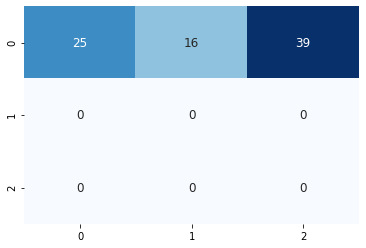

80/80 [==============================] - 0s 2ms/sample - loss: 2.6179 - accuracy: 0.3000


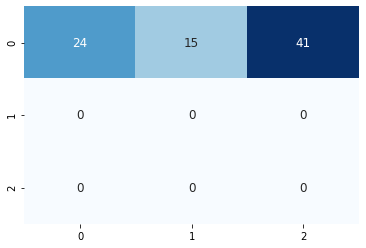

80/80 [==============================] - 0s 2ms/sample - loss: 2.5499 - accuracy: 0.3250


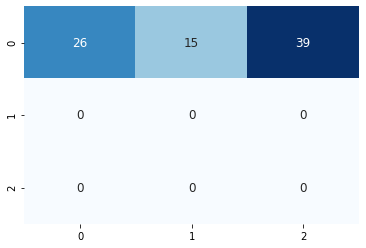

80/80 [==============================] - 0s 2ms/sample - loss: 2.7067 - accuracy: 0.3000


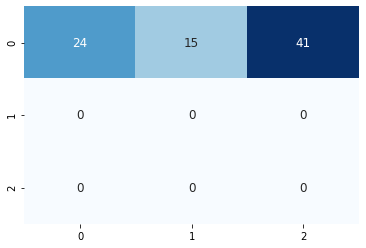

80/80 [==============================] - 0s 2ms/sample - loss: 2.6336 - accuracy: 0.2625


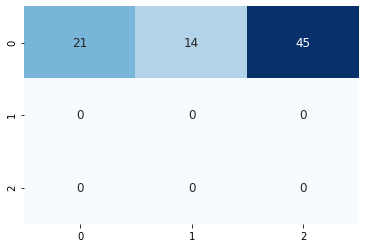

80/80 [==============================] - 0s 2ms/sample - loss: 2.5328 - accuracy: 0.3125


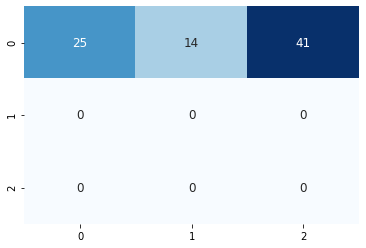

80/80 [==============================] - 0s 2ms/sample - loss: 2.7388 - accuracy: 0.2750


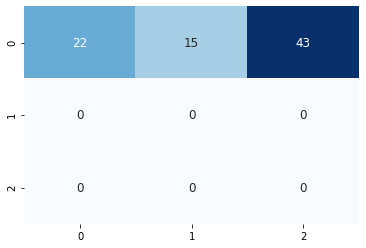

80/80 [==============================] - 0s 2ms/sample - loss: 2.6917 - accuracy: 0.2750


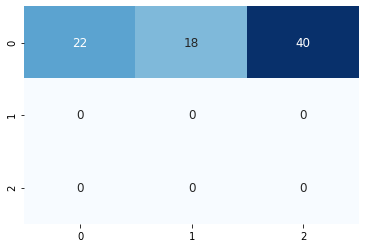

80/80 [==============================] - 0s 2ms/sample - loss: 2.5894 - accuracy: 0.2625


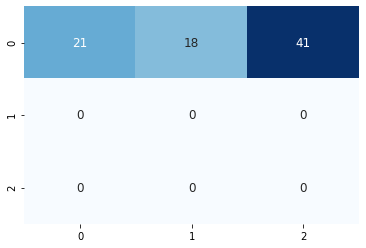

80/80 [==============================] - 0s 2ms/sample - loss: 2.5993 - accuracy: 0.2625


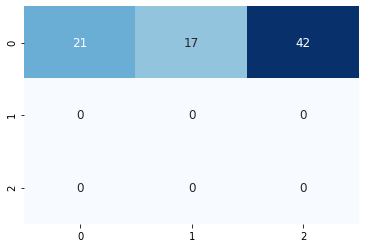

80/80 [==============================] - 0s 2ms/sample - loss: 2.6513 - accuracy: 0.2625


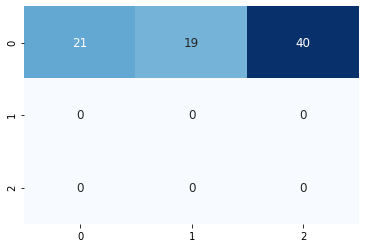

80/80 [==============================] - 0s 2ms/sample - loss: 2.5818 - accuracy: 0.2875


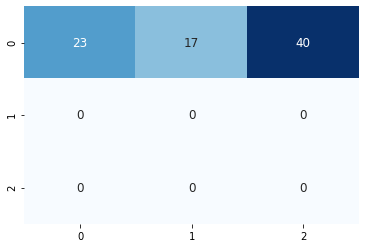

80/80 [==============================] - 0s 2ms/sample - loss: 2.5516 - accuracy: 0.3000


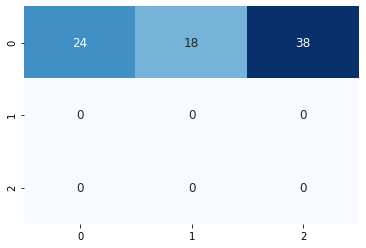

80/80 [==============================] - 0s 2ms/sample - loss: 2.5648 - accuracy: 0.2625


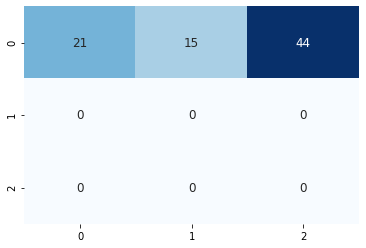

80/80 [==============================] - 0s 2ms/sample - loss: 2.5605 - accuracy: 0.3000


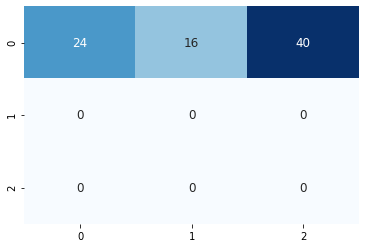

80/80 [==============================] - 0s 2ms/sample - loss: 2.6067 - accuracy: 0.2250


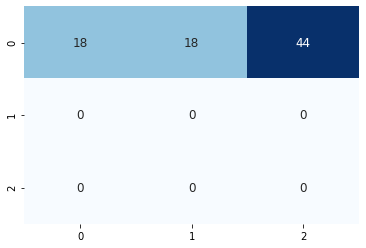

80/80 [==============================] - 0s 2ms/sample - loss: 2.5568 - accuracy: 0.2500


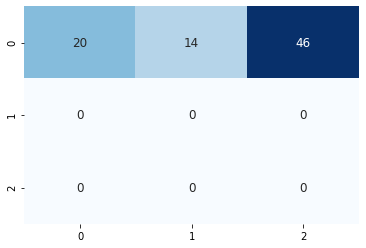

80/80 [==============================] - 0s 2ms/sample - loss: 2.6431 - accuracy: 0.2125


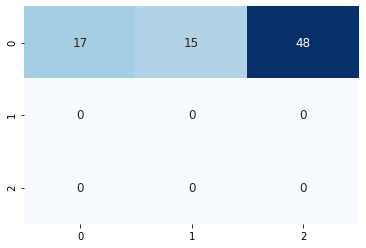

80/80 [==============================] - 0s 2ms/sample - loss: 2.7446 - accuracy: 0.2250


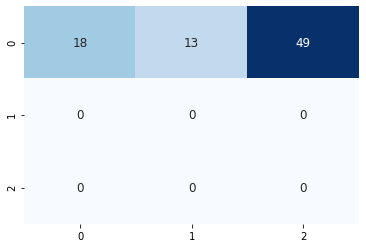

80/80 [==============================] - 0s 2ms/sample - loss: 2.6215 - accuracy: 0.2250


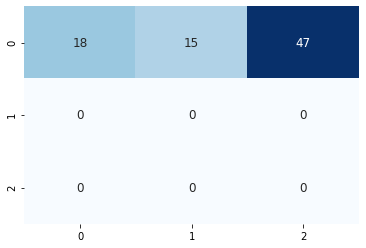

80/80 [==============================] - 0s 2ms/sample - loss: 2.6631 - accuracy: 0.2375


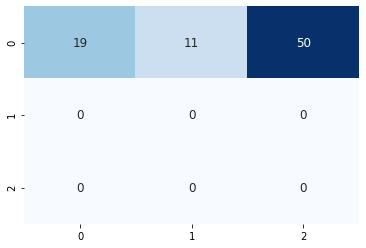

80/80 [==============================] - 0s 2ms/sample - loss: 2.9009 - accuracy: 0.2375


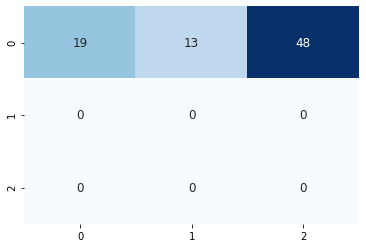

80/80 [==============================] - 0s 2ms/sample - loss: 2.7216 - accuracy: 0.2625


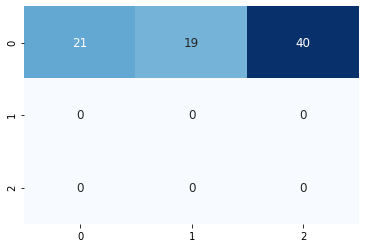

80/80 [==============================] - 0s 2ms/sample - loss: 2.7283 - accuracy: 0.1875


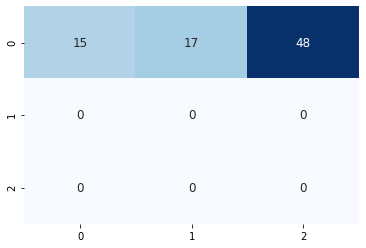

80/80 [==============================] - 0s 2ms/sample - loss: 2.6920 - accuracy: 0.2625


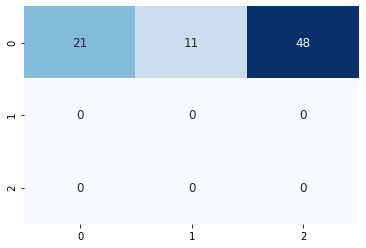

80/80 [==============================] - 0s 2ms/sample - loss: 2.7662 - accuracy: 0.2375


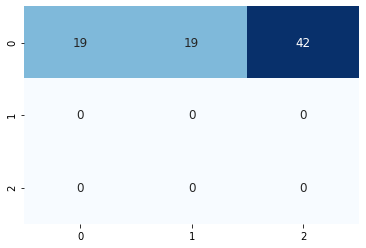

80/80 [==============================] - 0s 2ms/sample - loss: 2.6796 - accuracy: 0.2250


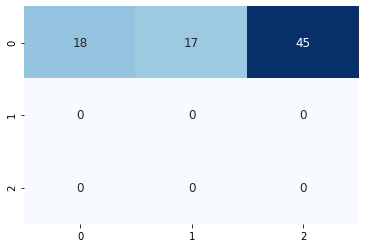

80/80 [==============================] - 0s 2ms/sample - loss: 2.6302 - accuracy: 0.2500


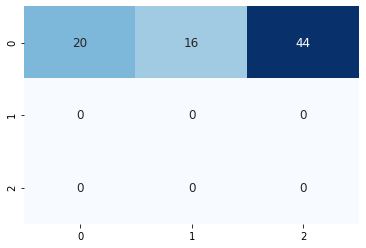

80/80 [==============================] - 0s 2ms/sample - loss: 2.7808 - accuracy: 0.1875


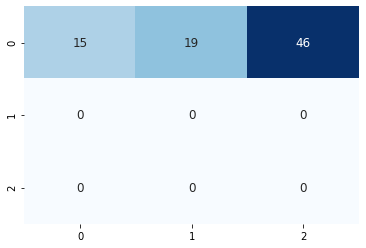

80/80 [==============================] - 0s 2ms/sample - loss: 2.8928 - accuracy: 0.2375


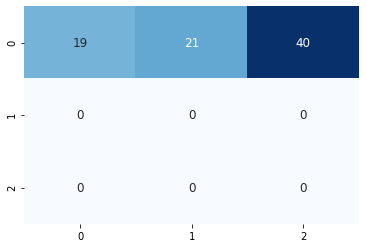

80/80 [==============================] - 0s 2ms/sample - loss: 2.6917 - accuracy: 0.2375


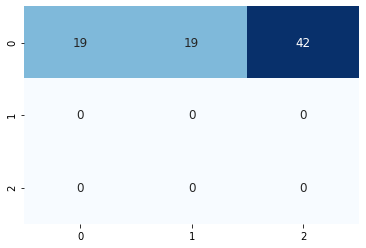

80/80 [==============================] - 0s 2ms/sample - loss: 2.6743 - accuracy: 0.2250


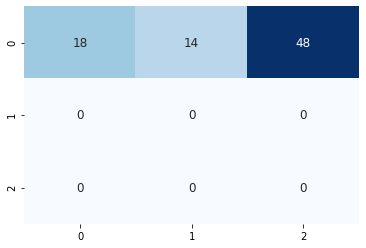

80/80 [==============================] - 0s 2ms/sample - loss: 2.6192 - accuracy: 0.2000


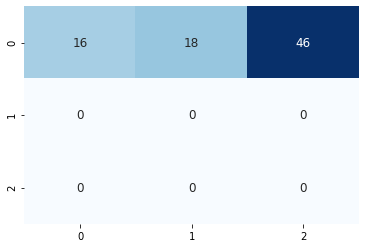

80/80 [==============================] - 0s 2ms/sample - loss: 2.5675 - accuracy: 0.2375


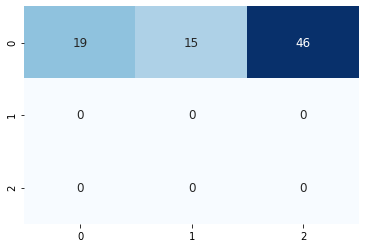

Found 22848 validated image filenames belonging to 3 classes.
Found 15232 validated image filenames belonging to 3 classes.
Model_loaded
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 178 steps, validate for 119 steps
Epoch 1/50
178/178 [==============================] - 99s 555ms/step - loss: 0.8291 - accuracy: 0.6012 - val_loss: 1.0763 - val_accuracy: 0.6100
Epoch 2/50
178/178 [==============================] - 98s 550ms/step - loss: 0.5974 - accuracy: 0.7272 - val_loss: 1.1628 - val_accuracy: 0.5146
Epoch 3/50
178/178 [==============================] - 98s 550ms/step - loss: 0.4756 - accuracy: 0.7887 - val_loss: 1.4086 - val_accuracy: 0.4728
Epoch 4/50
178/178 [==============================] - 99s 553ms/step - loss: 0.3965 - accuracy: 0.8247 - val_loss: 1.5906 - val_accuracy: 0.5538
Epoch 00004: early stopping
80/80 [==============================] - 0s 5ms/sample - loss: 2.0625 - accuracy: 0.2250


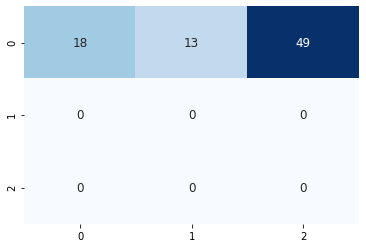

80/80 [==============================] - 0s 2ms/sample - loss: 1.9947 - accuracy: 0.1875


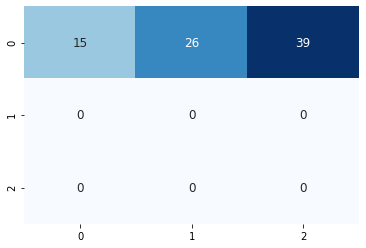

80/80 [==============================] - 0s 2ms/sample - loss: 1.9466 - accuracy: 0.2625


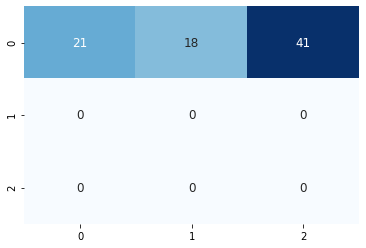

80/80 [==============================] - 0s 2ms/sample - loss: 2.2770 - accuracy: 0.1625


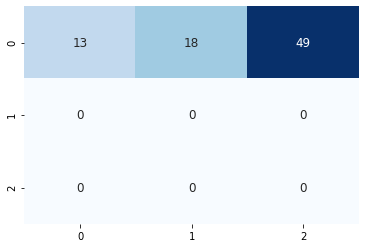

80/80 [==============================] - 0s 2ms/sample - loss: 2.1560 - accuracy: 0.1625


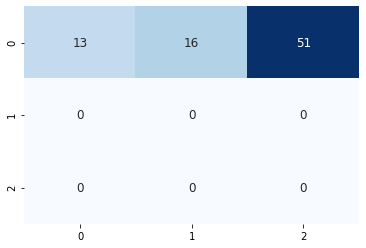

80/80 [==============================] - 0s 2ms/sample - loss: 2.0057 - accuracy: 0.1875


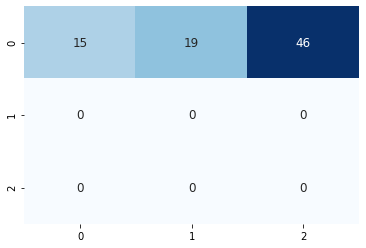

80/80 [==============================] - 0s 2ms/sample - loss: 2.1594 - accuracy: 0.1750


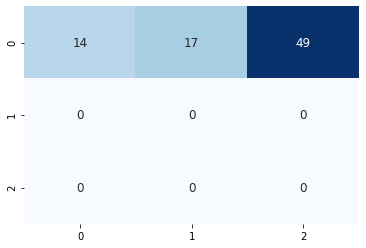

80/80 [==============================] - 0s 2ms/sample - loss: 2.2223 - accuracy: 0.1375


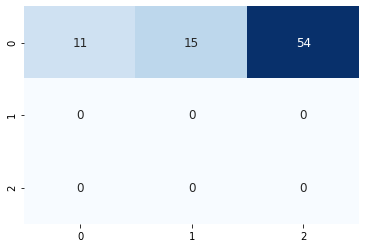

80/80 [==============================] - 0s 2ms/sample - loss: 2.0904 - accuracy: 0.2125


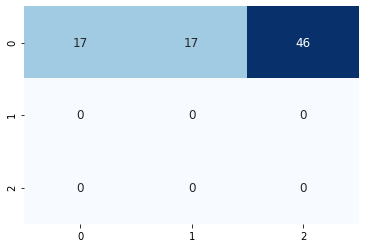

80/80 [==============================] - 0s 2ms/sample - loss: 2.2010 - accuracy: 0.1750


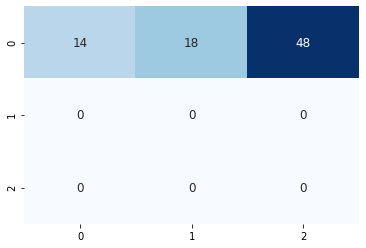

80/80 [==============================] - 0s 2ms/sample - loss: 2.3185 - accuracy: 0.1875


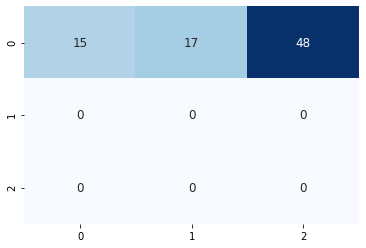

80/80 [==============================] - 0s 2ms/sample - loss: 2.2304 - accuracy: 0.1375


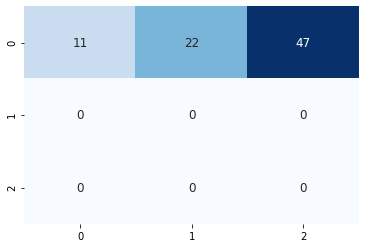

80/80 [==============================] - 0s 2ms/sample - loss: 2.3404 - accuracy: 0.1875


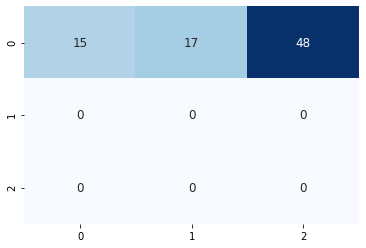

80/80 [==============================] - 0s 2ms/sample - loss: 2.1735 - accuracy: 0.1750


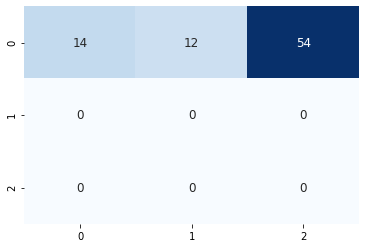

80/80 [==============================] - 0s 2ms/sample - loss: 2.1842 - accuracy: 0.1875


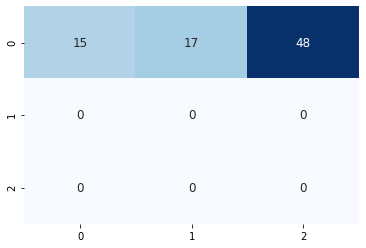

80/80 [==============================] - 0s 2ms/sample - loss: 2.3408 - accuracy: 0.1875


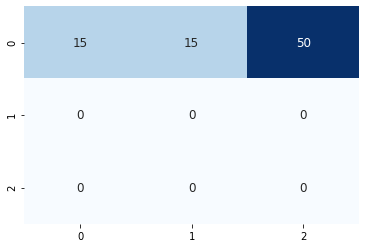

80/80 [==============================] - 0s 2ms/sample - loss: 2.2946 - accuracy: 0.2000


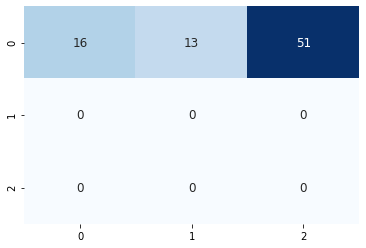

80/80 [==============================] - 0s 2ms/sample - loss: 2.4055 - accuracy: 0.1500


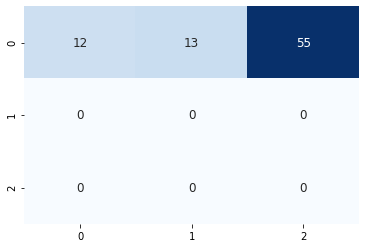

80/80 [==============================] - 0s 2ms/sample - loss: 2.4673 - accuracy: 0.1375


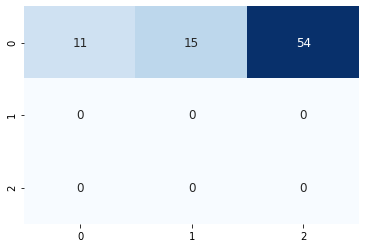

80/80 [==============================] - 0s 2ms/sample - loss: 2.1918 - accuracy: 0.1750


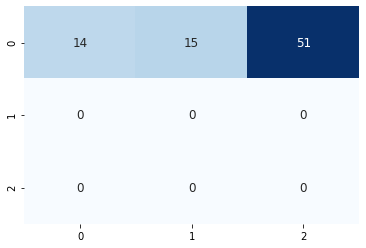

80/80 [==============================] - 0s 2ms/sample - loss: 2.4645 - accuracy: 0.1500


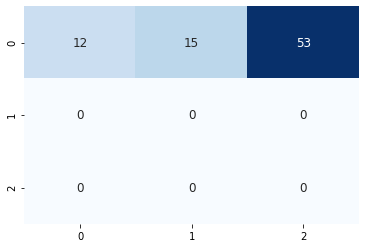

80/80 [==============================] - 0s 2ms/sample - loss: 2.5371 - accuracy: 0.1375


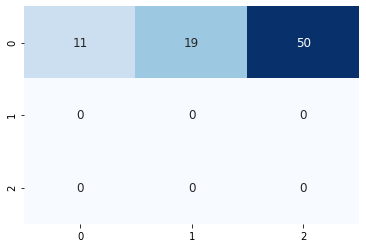

80/80 [==============================] - 0s 2ms/sample - loss: 2.3554 - accuracy: 0.2250


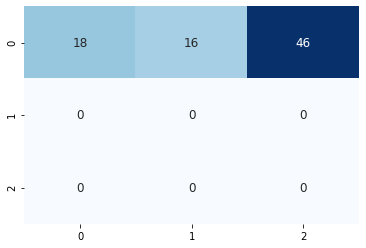

80/80 [==============================] - 0s 2ms/sample - loss: 2.3418 - accuracy: 0.1500


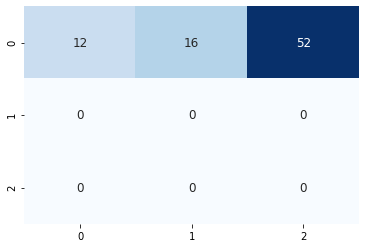

80/80 [==============================] - 0s 2ms/sample - loss: 2.5291 - accuracy: 0.1125


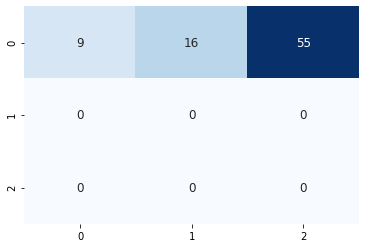

80/80 [==============================] - 0s 2ms/sample - loss: 2.5471 - accuracy: 0.1500


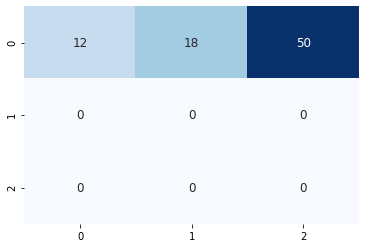

80/80 [==============================] - 0s 2ms/sample - loss: 2.5206 - accuracy: 0.2000


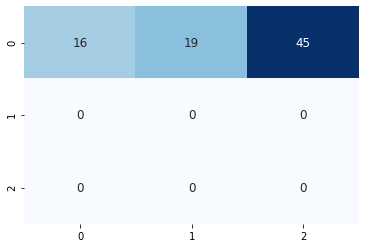

80/80 [==============================] - 0s 2ms/sample - loss: 2.4340 - accuracy: 0.2125


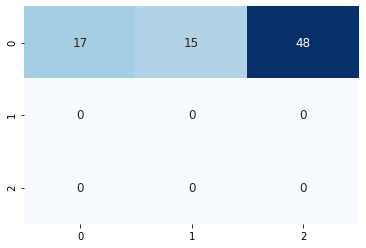

80/80 [==============================] - 0s 2ms/sample - loss: 2.4846 - accuracy: 0.1625


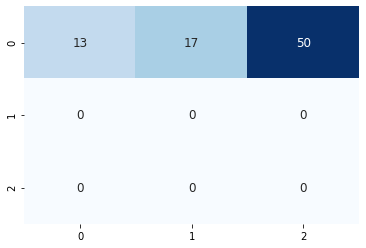

80/80 [==============================] - 0s 2ms/sample - loss: 2.5657 - accuracy: 0.2000


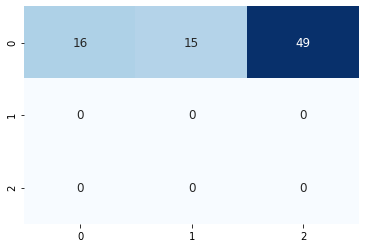

80/80 [==============================] - 0s 2ms/sample - loss: 2.3960 - accuracy: 0.1750


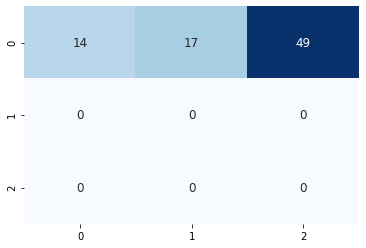

80/80 [==============================] - 0s 2ms/sample - loss: 2.4341 - accuracy: 0.1250


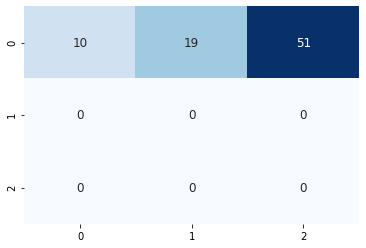

80/80 [==============================] - 0s 2ms/sample - loss: 2.3988 - accuracy: 0.1500


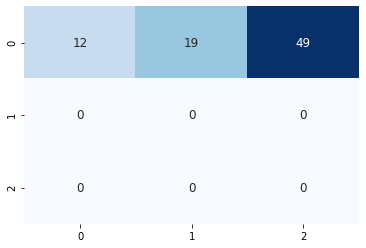

80/80 [==============================] - 0s 2ms/sample - loss: 2.4126 - accuracy: 0.1625


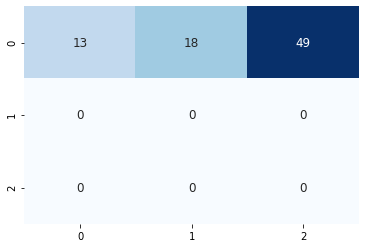

Found 22848 validated image filenames belonging to 3 classes.
Found 15232 validated image filenames belonging to 3 classes.
Model_loaded
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 89 steps, validate for 59 steps
Epoch 1/50
89/89 [==============================] - 104s 1s/step - loss: 0.8871 - accuracy: 0.5802 - val_loss: 1.1481 - val_accuracy: 0.6402
Epoch 2/50
89/89 [==============================] - 102s 1s/step - loss: 0.6667 - accuracy: 0.6938 - val_loss: 1.0876 - val_accuracy: 0.6312
Epoch 3/50
89/89 [==============================] - 104s 1s/step - loss: 0.5298 - accuracy: 0.7662 - val_loss: 1.0944 - val_accuracy: 0.6116
Epoch 4/50
89/89 [==============================] - 103s 1s/step - loss: 0.4389 - accuracy: 0.8072 - val_loss: 1.1496 - val_accuracy: 0.5291
Epoch 5/50
89/89 [==============================] - 102s 1s/step - loss: 0.3622 - accuracy: 0.8450 - val_loss: 1.3548 - val_accuracy: 0.4886
Epoch 00005: early stopping
80/80 [==============================]

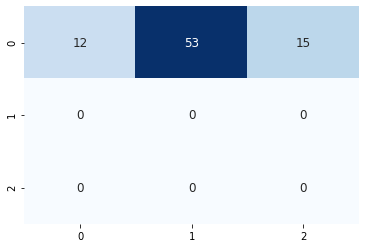

80/80 [==============================] - 0s 2ms/sample - loss: 2.1086 - accuracy: 0.1125


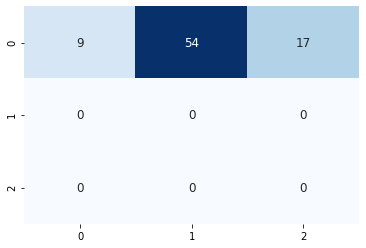

80/80 [==============================] - 0s 2ms/sample - loss: 2.0488 - accuracy: 0.1375


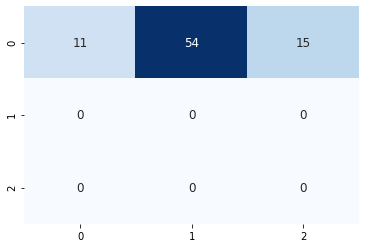

80/80 [==============================] - 0s 2ms/sample - loss: 2.2155 - accuracy: 0.1250


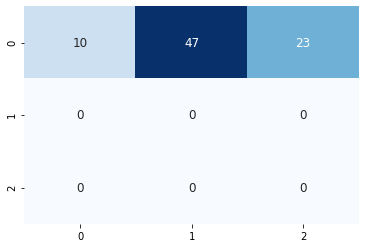

80/80 [==============================] - 0s 2ms/sample - loss: 2.2766 - accuracy: 0.0750


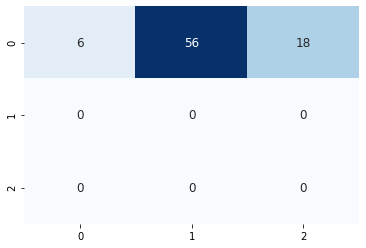

80/80 [==============================] - 0s 2ms/sample - loss: 2.1128 - accuracy: 0.1000


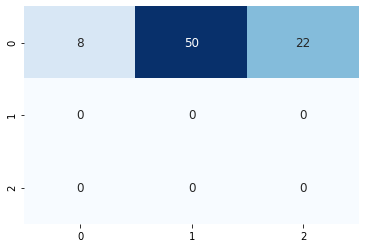

80/80 [==============================] - 0s 2ms/sample - loss: 2.2480 - accuracy: 0.0625


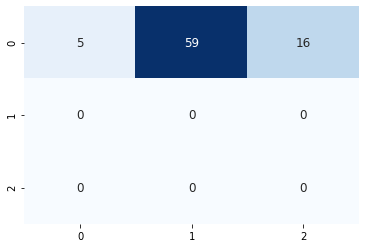

80/80 [==============================] - 0s 2ms/sample - loss: 2.3342 - accuracy: 0.0500


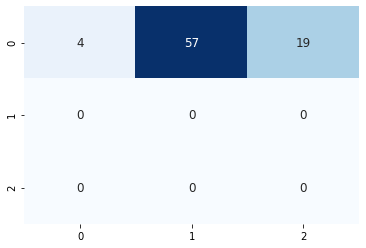

80/80 [==============================] - 0s 2ms/sample - loss: 2.2288 - accuracy: 0.1000


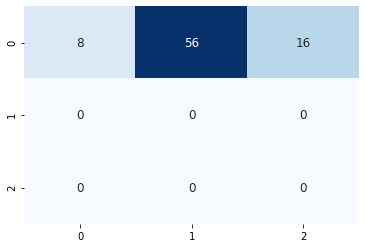

80/80 [==============================] - 0s 2ms/sample - loss: 2.2208 - accuracy: 0.1125


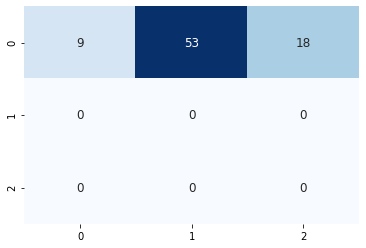

80/80 [==============================] - 0s 2ms/sample - loss: 2.1927 - accuracy: 0.0875


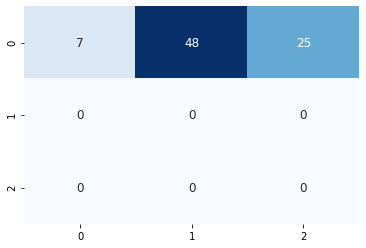

80/80 [==============================] - 0s 2ms/sample - loss: 2.1353 - accuracy: 0.0875


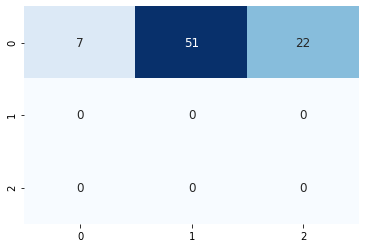

80/80 [==============================] - 0s 2ms/sample - loss: 2.2161 - accuracy: 0.0875


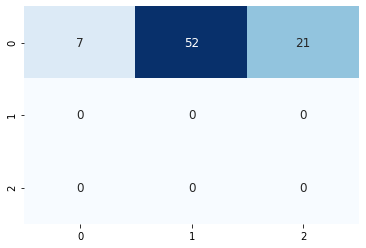

80/80 [==============================] - 0s 2ms/sample - loss: 2.0932 - accuracy: 0.1000


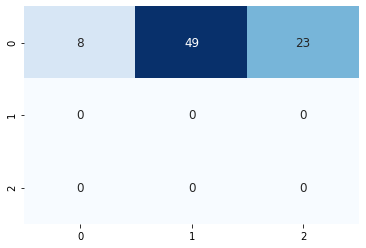

80/80 [==============================] - 0s 2ms/sample - loss: 2.1864 - accuracy: 0.0750


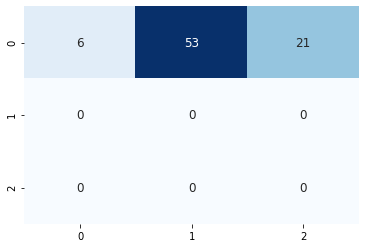

80/80 [==============================] - 0s 2ms/sample - loss: 2.1685 - accuracy: 0.1250


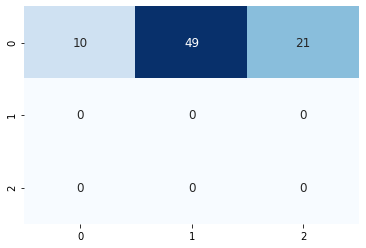

80/80 [==============================] - 0s 2ms/sample - loss: 2.1617 - accuracy: 0.1000


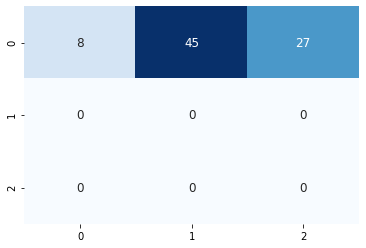

80/80 [==============================] - 0s 2ms/sample - loss: 2.0927 - accuracy: 0.0750


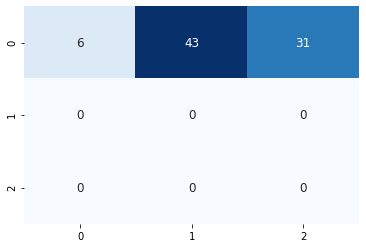

80/80 [==============================] - 0s 2ms/sample - loss: 2.2289 - accuracy: 0.0750


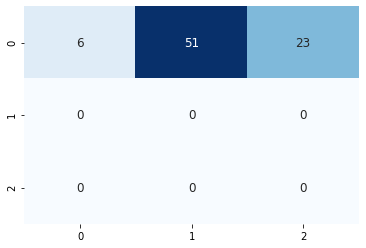

80/80 [==============================] - 0s 2ms/sample - loss: 2.0984 - accuracy: 0.1125


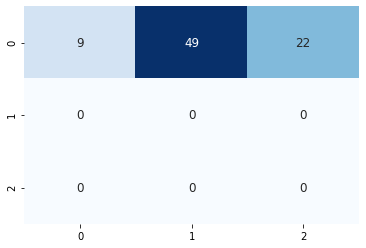

80/80 [==============================] - 0s 2ms/sample - loss: 2.3061 - accuracy: 0.0750


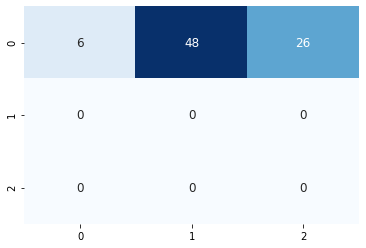

80/80 [==============================] - 0s 2ms/sample - loss: 2.2776 - accuracy: 0.1000


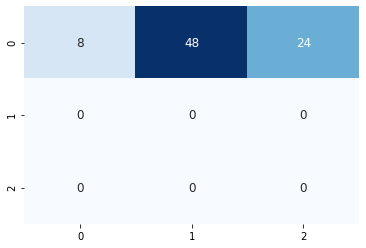

80/80 [==============================] - 0s 2ms/sample - loss: 2.0985 - accuracy: 0.1000


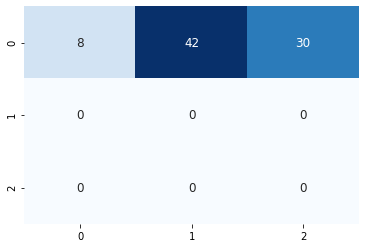

80/80 [==============================] - 0s 2ms/sample - loss: 2.2161 - accuracy: 0.1375


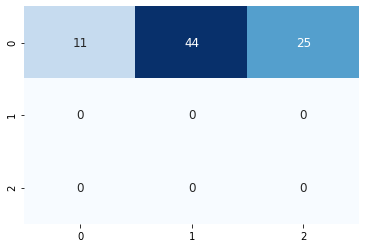

80/80 [==============================] - 0s 2ms/sample - loss: 2.2457 - accuracy: 0.0625


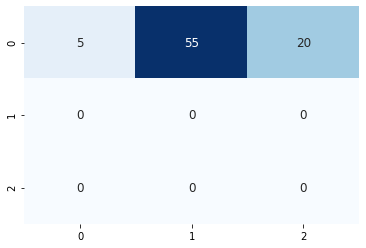

80/80 [==============================] - 0s 2ms/sample - loss: 2.3246 - accuracy: 0.0750


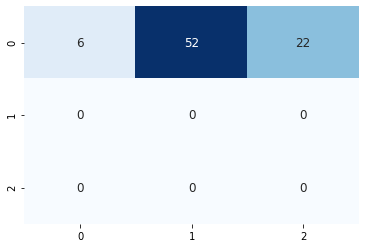

80/80 [==============================] - 0s 2ms/sample - loss: 2.2642 - accuracy: 0.1125


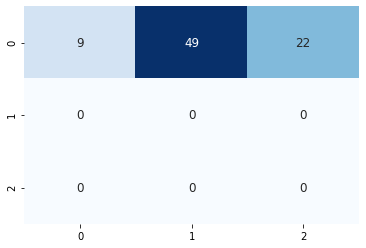

80/80 [==============================] - 0s 2ms/sample - loss: 2.2474 - accuracy: 0.0875


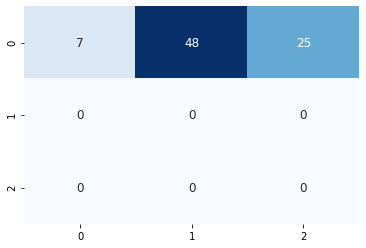

80/80 [==============================] - 0s 2ms/sample - loss: 2.3126 - accuracy: 0.0625


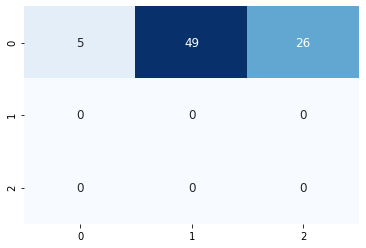

80/80 [==============================] - 0s 2ms/sample - loss: 2.3488 - accuracy: 0.1000


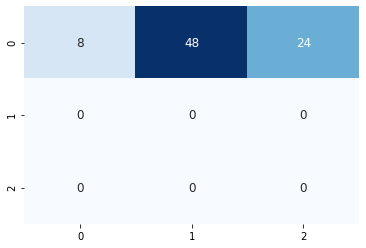

80/80 [==============================] - 0s 2ms/sample - loss: 2.2809 - accuracy: 0.0875


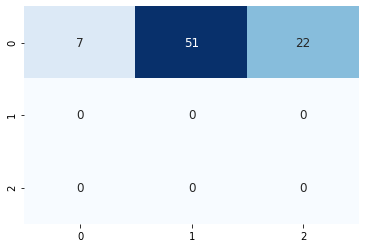

80/80 [==============================] - 0s 2ms/sample - loss: 2.2831 - accuracy: 0.1125


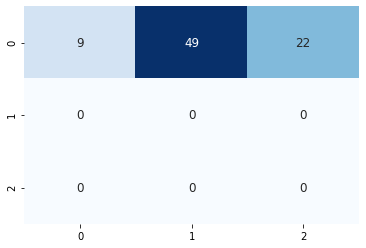

80/80 [==============================] - 0s 2ms/sample - loss: 2.2696 - accuracy: 0.0875


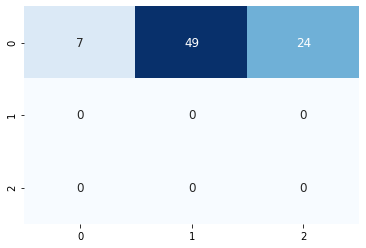

80/80 [==============================] - 0s 2ms/sample - loss: 2.1858 - accuracy: 0.1125


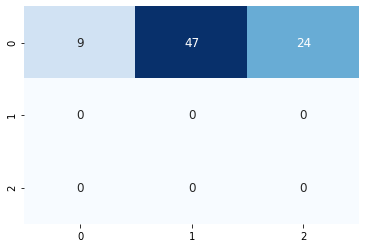

Found 22848 validated image filenames belonging to 3 classes.
Found 15232 validated image filenames belonging to 3 classes.
Model_loaded
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 89 steps, validate for 59 steps
Epoch 1/50
89/89 [==============================] - 104s 1s/step - loss: 0.8577 - accuracy: 0.5944 - val_loss: 1.0968 - val_accuracy: 0.5858
Epoch 2/50
89/89 [==============================] - 105s 1s/step - loss: 0.6284 - accuracy: 0.7134 - val_loss: 1.0915 - val_accuracy: 0.5773
Epoch 3/50
89/89 [==============================] - 104s 1s/step - loss: 0.5095 - accuracy: 0.7701 - val_loss: 1.0872 - val_accuracy: 0.5481
Epoch 4/50
89/89 [==============================] - 102s 1s/step - loss: 0.4234 - accuracy: 0.8123 - val_loss: 1.1817 - val_accuracy: 0.5093
Epoch 5/50
89/89 [==============================] - 102s 1s/step - loss: 0.3630 - accuracy: 0.8416 - val_loss: 1.3448 - val_accuracy: 0.4689
Epoch 6/50
89/89 [==============================] - 104s 1s/step -

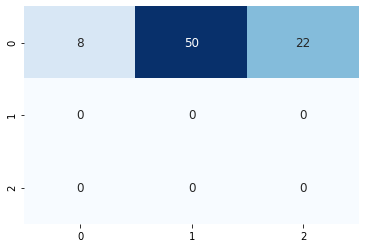

80/80 [==============================] - 0s 2ms/sample - loss: 3.6250 - accuracy: 0.0750


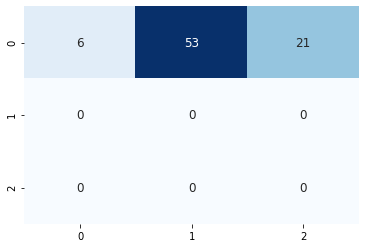

80/80 [==============================] - 0s 2ms/sample - loss: 3.6152 - accuracy: 0.1000


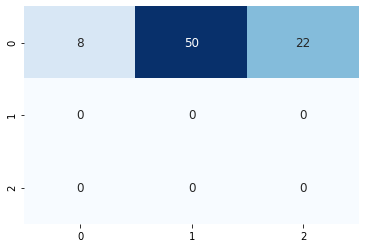

80/80 [==============================] - 0s 2ms/sample - loss: 3.9289 - accuracy: 0.0500


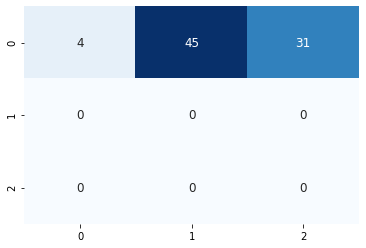

80/80 [==============================] - 0s 2ms/sample - loss: 3.9242 - accuracy: 0.0625


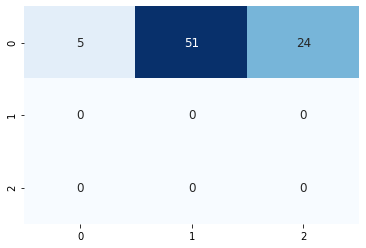

80/80 [==============================] - 0s 2ms/sample - loss: 3.4812 - accuracy: 0.1250


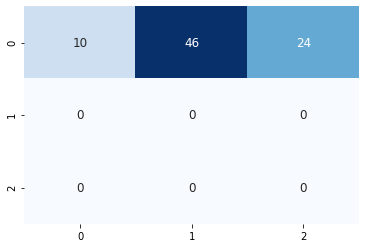

80/80 [==============================] - 0s 2ms/sample - loss: 3.7983 - accuracy: 0.0875


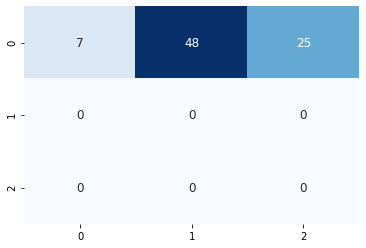

80/80 [==============================] - 0s 2ms/sample - loss: 3.8367 - accuracy: 0.1000


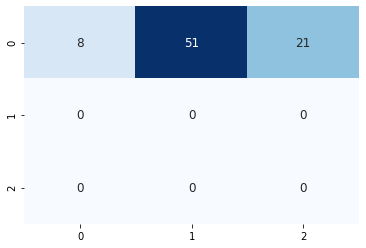

80/80 [==============================] - 0s 2ms/sample - loss: 3.4699 - accuracy: 0.1125


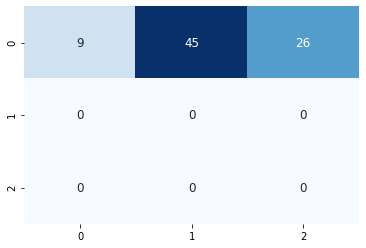

80/80 [==============================] - 0s 2ms/sample - loss: 3.6171 - accuracy: 0.0750


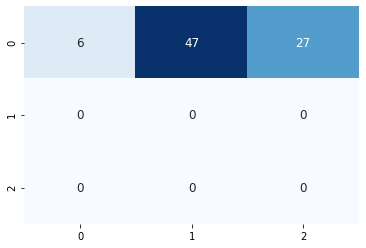

80/80 [==============================] - 0s 2ms/sample - loss: 3.5817 - accuracy: 0.0875


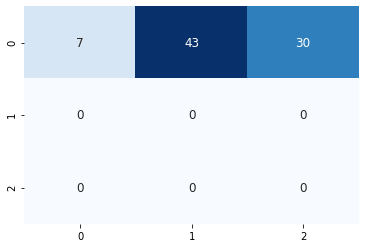

80/80 [==============================] - 0s 2ms/sample - loss: 3.3271 - accuracy: 0.1500


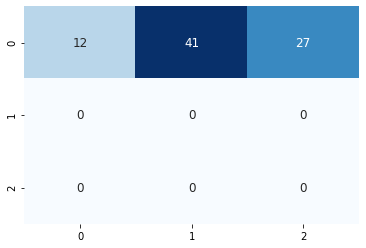

80/80 [==============================] - 0s 2ms/sample - loss: 3.4304 - accuracy: 0.0875


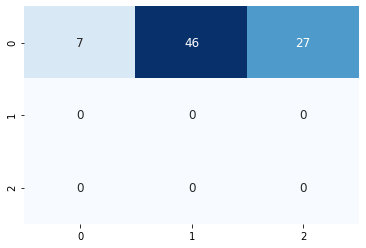

80/80 [==============================] - 0s 2ms/sample - loss: 3.3561 - accuracy: 0.0875


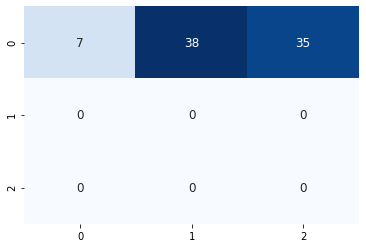

80/80 [==============================] - 0s 2ms/sample - loss: 3.4739 - accuracy: 0.1000


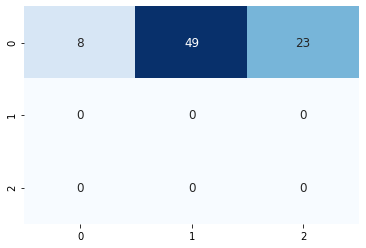

80/80 [==============================] - 0s 2ms/sample - loss: 3.4529 - accuracy: 0.0875


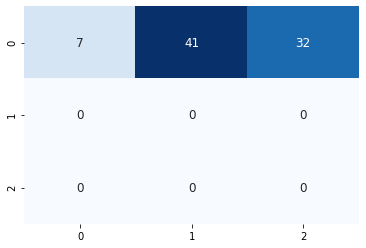

80/80 [==============================] - 0s 2ms/sample - loss: 3.4485 - accuracy: 0.0750


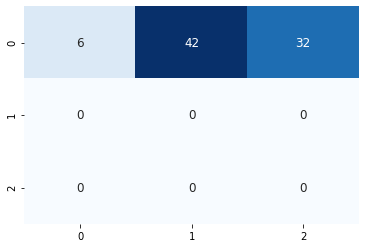

80/80 [==============================] - 0s 2ms/sample - loss: 3.4511 - accuracy: 0.0875


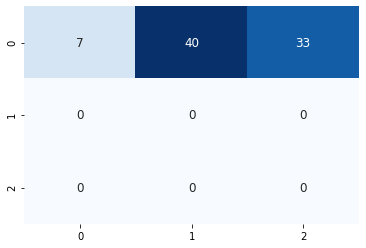

80/80 [==============================] - 0s 2ms/sample - loss: 3.6419 - accuracy: 0.1000


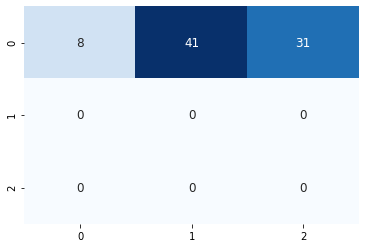

80/80 [==============================] - 0s 2ms/sample - loss: 3.4975 - accuracy: 0.0750


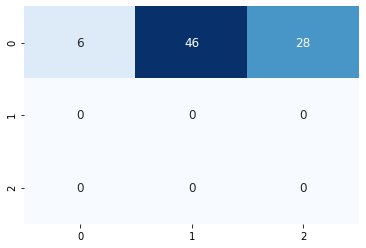

80/80 [==============================] - 0s 2ms/sample - loss: 3.6585 - accuracy: 0.0625


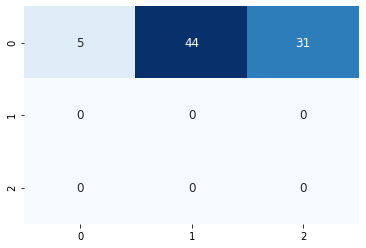

80/80 [==============================] - 0s 2ms/sample - loss: 3.7193 - accuracy: 0.0625


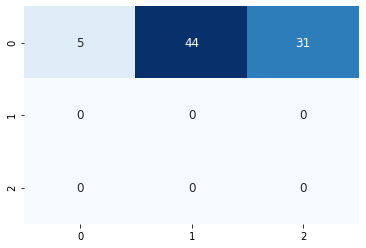

80/80 [==============================] - 0s 2ms/sample - loss: 3.4514 - accuracy: 0.1250


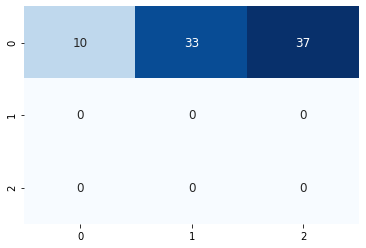

80/80 [==============================] - 0s 2ms/sample - loss: 3.5094 - accuracy: 0.1000


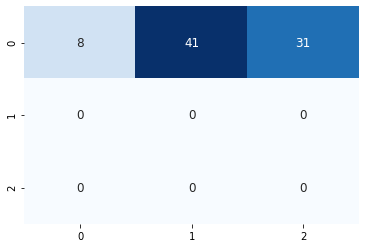

80/80 [==============================] - 0s 2ms/sample - loss: 3.6155 - accuracy: 0.0750


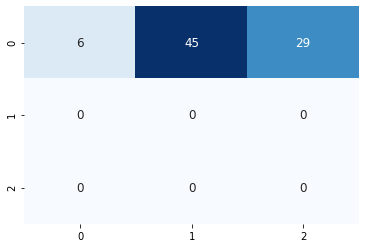

80/80 [==============================] - 0s 2ms/sample - loss: 3.7535 - accuracy: 0.0625


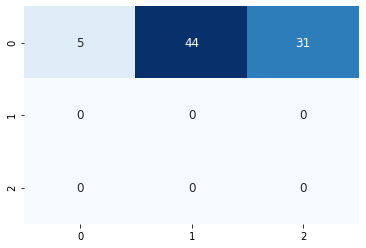

80/80 [==============================] - 0s 2ms/sample - loss: 3.6065 - accuracy: 0.1000


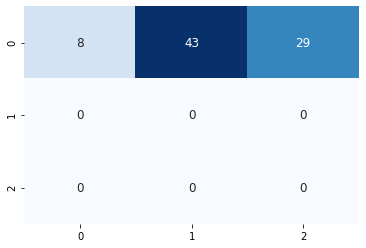

80/80 [==============================] - 0s 2ms/sample - loss: 3.5957 - accuracy: 0.1000


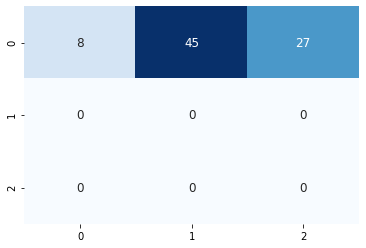

80/80 [==============================] - 0s 2ms/sample - loss: 3.5759 - accuracy: 0.0875


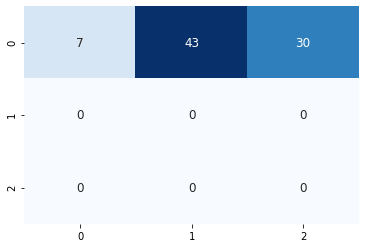

80/80 [==============================] - 0s 2ms/sample - loss: 3.6574 - accuracy: 0.1125


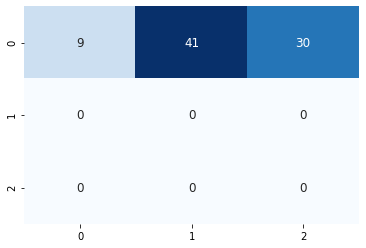

80/80 [==============================] - 0s 2ms/sample - loss: 3.4831 - accuracy: 0.1125


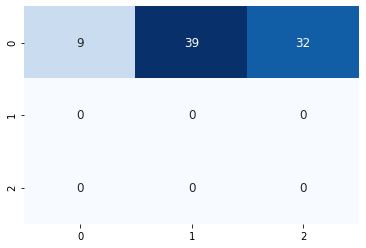

80/80 [==============================] - 0s 2ms/sample - loss: 3.5559 - accuracy: 0.0875


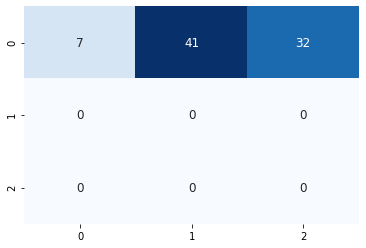

80/80 [==============================] - 0s 2ms/sample - loss: 3.5637 - accuracy: 0.1000


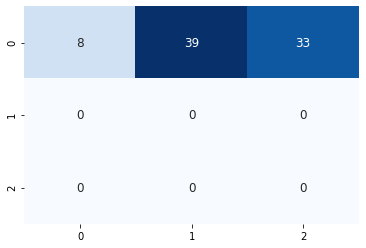

80/80 [==============================] - 0s 2ms/sample - loss: 3.4438 - accuracy: 0.1250


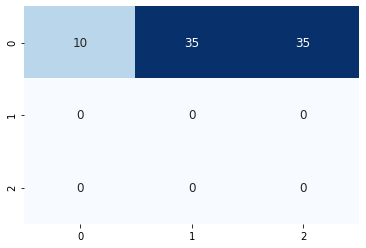

 50%|█████     | 1/2 [34:18<34:18, 2058.63s/it]

Found 22848 validated image filenames belonging to 3 classes.
Found 15232 validated image filenames belonging to 3 classes.
Model_loaded
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 178 steps, validate for 119 steps
Epoch 1/50
178/178 [==============================] - 105s 592ms/step - loss: 0.9173 - accuracy: 0.5625 - val_loss: 1.3073 - val_accuracy: 0.5678
Epoch 2/50
178/178 [==============================] - 103s 578ms/step - loss: 0.7591 - accuracy: 0.6488 - val_loss: 1.2660 - val_accuracy: 0.3841
Epoch 3/50
178/178 [==============================] - 104s 582ms/step - loss: 0.6635 - accuracy: 0.6980 - val_loss: 1.6413 - val_accuracy: 0.2997
Epoch 4/50
178/178 [==============================] - 101s 568ms/step - loss: 0.5840 - accuracy: 0.7413 - val_loss: 1.4814 - val_accuracy: 0.3661
Epoch 5/50
178/178 [==============================] - 98s 550ms/step - loss: 0.5310 - accuracy: 0.7618 - val_loss: 1.5353 - val_accuracy: 0.3304
Epoch 00005: early stopping
80/80 [=====

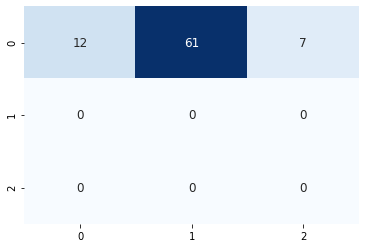

80/80 [==============================] - 0s 2ms/sample - loss: 2.2248 - accuracy: 0.1250


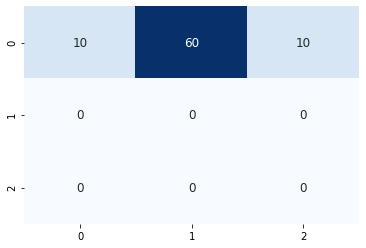

80/80 [==============================] - 0s 2ms/sample - loss: 2.2627 - accuracy: 0.1125


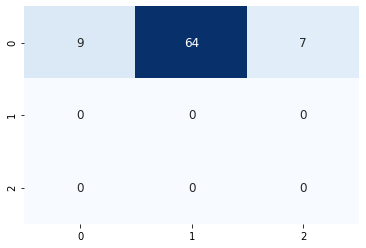

80/80 [==============================] - 0s 2ms/sample - loss: 2.3364 - accuracy: 0.0875


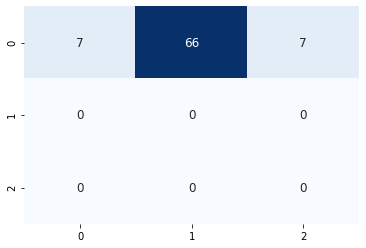

80/80 [==============================] - 0s 2ms/sample - loss: 2.2155 - accuracy: 0.1000


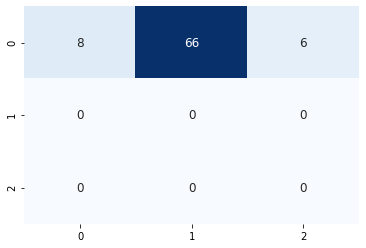

80/80 [==============================] - 0s 2ms/sample - loss: 2.0097 - accuracy: 0.1750


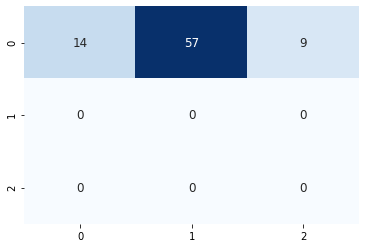

80/80 [==============================] - 0s 2ms/sample - loss: 2.2515 - accuracy: 0.0875


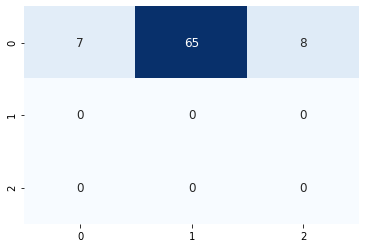

80/80 [==============================] - 0s 2ms/sample - loss: 2.2311 - accuracy: 0.1000


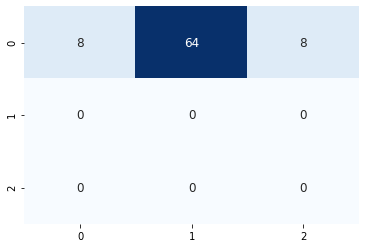

80/80 [==============================] - 0s 2ms/sample - loss: 2.3258 - accuracy: 0.0750


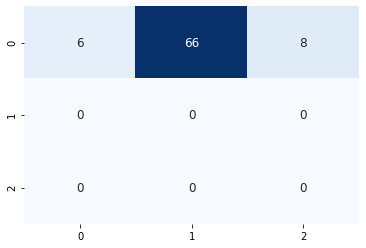

80/80 [==============================] - 0s 2ms/sample - loss: 2.2359 - accuracy: 0.1250


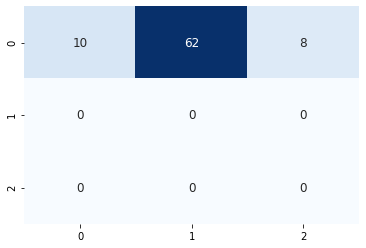

80/80 [==============================] - 0s 2ms/sample - loss: 2.2892 - accuracy: 0.0875


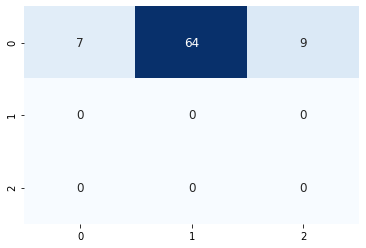

80/80 [==============================] - 0s 2ms/sample - loss: 2.1092 - accuracy: 0.1375


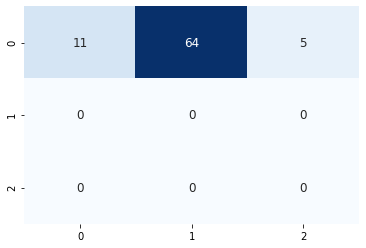

80/80 [==============================] - 0s 2ms/sample - loss: 2.0359 - accuracy: 0.1500


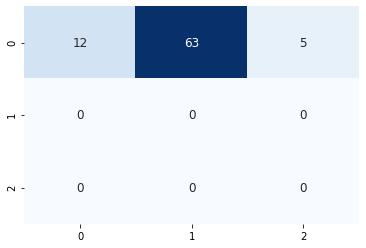

80/80 [==============================] - 0s 2ms/sample - loss: 2.0878 - accuracy: 0.1375


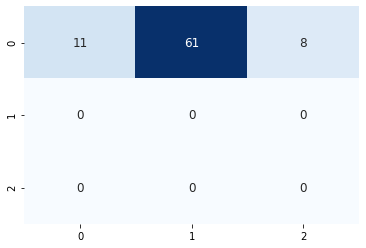

80/80 [==============================] - 0s 2ms/sample - loss: 2.1093 - accuracy: 0.1625


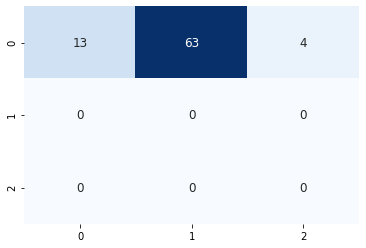

80/80 [==============================] - 0s 2ms/sample - loss: 2.0063 - accuracy: 0.1750


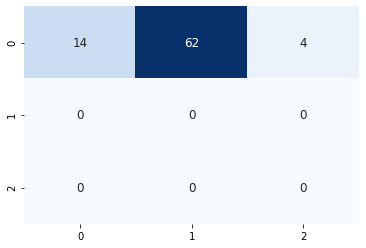

80/80 [==============================] - 0s 2ms/sample - loss: 2.0577 - accuracy: 0.0875


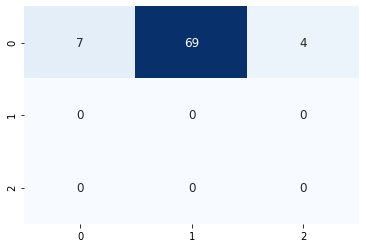

80/80 [==============================] - 0s 2ms/sample - loss: 2.0201 - accuracy: 0.1625


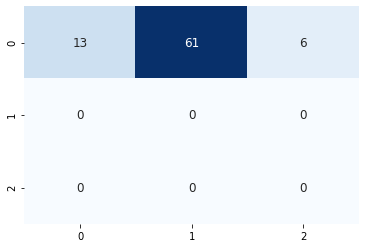

80/80 [==============================] - 0s 2ms/sample - loss: 2.0826 - accuracy: 0.1625


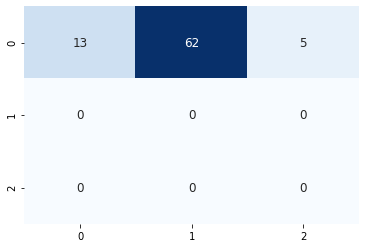

80/80 [==============================] - 0s 2ms/sample - loss: 1.9571 - accuracy: 0.1875


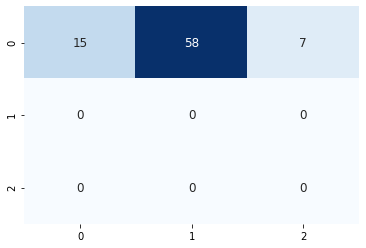

80/80 [==============================] - 0s 2ms/sample - loss: 2.1125 - accuracy: 0.1625


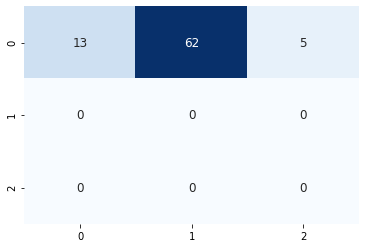

80/80 [==============================] - 0s 2ms/sample - loss: 2.0920 - accuracy: 0.1125


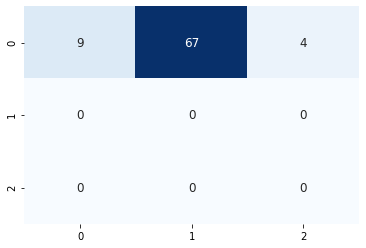

80/80 [==============================] - 0s 2ms/sample - loss: 2.0758 - accuracy: 0.2000


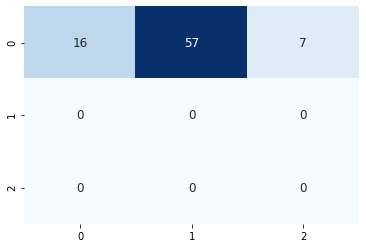

80/80 [==============================] - 0s 2ms/sample - loss: 2.0830 - accuracy: 0.1875


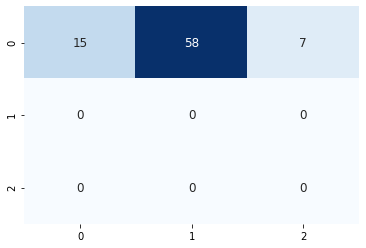

80/80 [==============================] - 0s 2ms/sample - loss: 2.0651 - accuracy: 0.1500


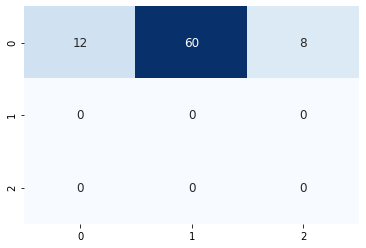

80/80 [==============================] - 0s 2ms/sample - loss: 2.2159 - accuracy: 0.1375


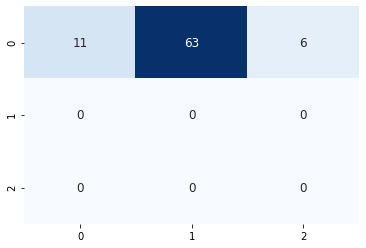

80/80 [==============================] - 0s 2ms/sample - loss: 2.1172 - accuracy: 0.1125


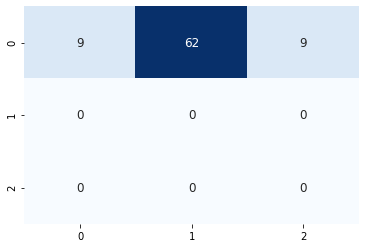

80/80 [==============================] - 0s 2ms/sample - loss: 2.0716 - accuracy: 0.1250


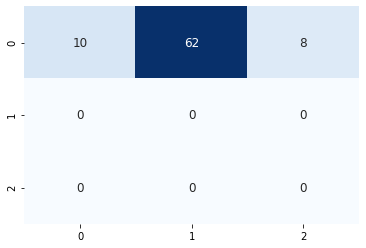

80/80 [==============================] - 0s 2ms/sample - loss: 2.1343 - accuracy: 0.1000


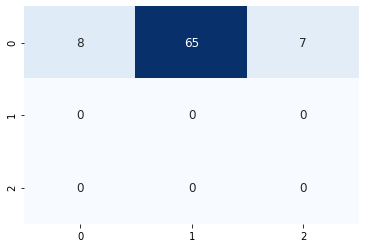

80/80 [==============================] - 0s 2ms/sample - loss: 2.2523 - accuracy: 0.1125


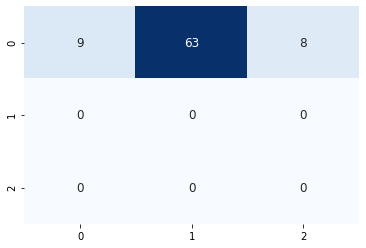

80/80 [==============================] - 0s 2ms/sample - loss: 2.0221 - accuracy: 0.1250


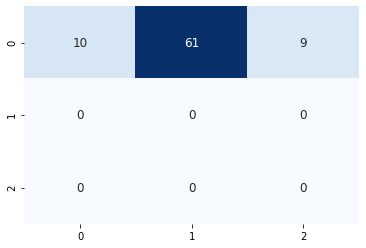

80/80 [==============================] - 0s 2ms/sample - loss: 2.0275 - accuracy: 0.1250


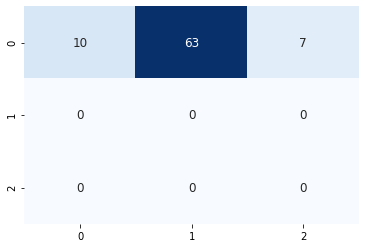

80/80 [==============================] - 0s 2ms/sample - loss: 2.0339 - accuracy: 0.1000


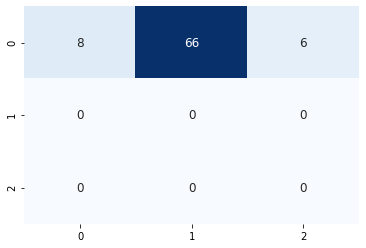

80/80 [==============================] - 0s 2ms/sample - loss: 2.0314 - accuracy: 0.1250


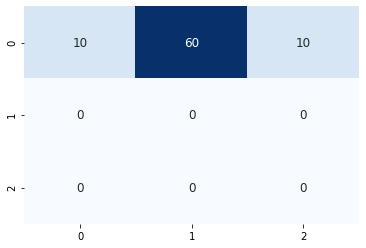

Found 22848 validated image filenames belonging to 3 classes.
Found 15232 validated image filenames belonging to 3 classes.
Model_loaded
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 178 steps, validate for 119 steps
Epoch 1/50
178/178 [==============================] - 100s 562ms/step - loss: 0.9041 - accuracy: 0.5654 - val_loss: 1.1759 - val_accuracy: 0.4789
Epoch 2/50
178/178 [==============================] - 100s 561ms/step - loss: 0.7528 - accuracy: 0.6608 - val_loss: 1.2224 - val_accuracy: 0.3774
Epoch 3/50
178/178 [==============================] - 98s 551ms/step - loss: 0.6618 - accuracy: 0.7052 - val_loss: 1.2938 - val_accuracy: 0.3428
Epoch 4/50
 85/178 [=============>................] - ETA: 31s - loss: 0.6039 - accuracy: 0.7320

In [ ]:
tot_results_accuracy = []
op = [Adam, RMSprop]
n_op = ['Adma', 'RMSP']
batch_size = [64,128,256]
act = ['relu', 'tanh' ]
comb = []
for a in tqdm.tqdm(act):
    for b in batch_size:
        
        for o, n in zip(op, n_op):

            comb.append(list((a,b, n)))
            
            

            train_leb = label(train)
            val_leb = label(validation)
            test_leb = label(test)
            train_cnn = Images_path(train)
            validation_cnn = Images_path(validation)


            data_train = {'id': train_cnn, 'labels':train_leb}
            data_val = {'id': validation_cnn, 'labels':val_leb}

            df_train = pd.DataFrame(data_train, columns = ['id', 'labels'])
            df_val = pd.DataFrame(data_val, columns = ['id', 'labels'])

            df_train['labels'] = df_train['labels'].astype(str)
            df_val['labels'] = df_val['labels'].astype(str)

            datagen=ImageDataGenerator(preprocessing_function = preprocess_input)

            train_generator=datagen.flow_from_dataframe(dataframe=df_train, directory = None , x_col="id", y_col="labels",color_mode="rgb", 
                                                        class_mode="categorical", target_size=(256, 256), batch_size=b)

            val_generator=datagen.flow_from_dataframe(dataframe=df_val, directory = None , x_col="id", y_col="labels",color_mode="rgb", 
                                                        class_mode="categorical", target_size=(256, 256), batch_size=b)


            weights = class_weight.compute_class_weight('balanced', np.unique(train_leb), train_leb)

            weights = dict(enumerate(weights))



            es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=3)

            pretrained_model = VGG16(weights='imagenet',include_top=False, input_shape=(256, 256, 3))

            base_model = Model(inputs=pretrained_model.input, outputs=pretrained_model.get_layer('block3_pool').output)

            print('Model_loaded')

            m4 = Sequential()
            m4.add(base_model)


            m4.add(BatchNormalization())
            m4.add(GlobalAveragePooling2D())
            m4.add(Dense(128, activation=a))
            m4.add(BatchNormalization())
            m4.add(Dense(64, activation=a))
            m4.add(BatchNormalization())
            m4.add(Activation(a))
            m4.add(Dense(3,activation='softmax'))


            base_model.trainable = False

            opt = o(lr=1e-3)

            m4.compile(loss= keras.losses.categorical_crossentropy, optimizer=opt, metrics = ['accuracy'])



            epochs = 50

            STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
            STEP_SIZE_VALID=val_generator.n//val_generator.batch_size

            m4_h = m4.fit(train_generator, steps_per_epoch = STEP_SIZE_TRAIN, validation_data = val_generator, 
                          validation_steps = STEP_SIZE_VALID , callbacks = [es],
                          class_weight = weights, epochs=epochs, verbose = 1)


        

            l = []
            for t in new_time:
                for i in test:
                    if t in i:
                        l.append((i))


            grouped = {}
            for elem in l:
                key = elem.split('.tiff')[0].split('_')[5]
                grouped.setdefault(key, []).append(elem)
            grouped = grouped.values()

            test_data = list(grouped)

            r = []

            for ix ,_ in enumerate(test_data):
                r.append(time_step_acc(test_data[ix],m4))

            tot_results_accuracy.append(r)
            

            del m4
            K.clear_session()


In [26]:
res = np.mean(tot_results_accuracy)
res

15.257352875436053

In [28]:
comb

[['relu', 128, 'Adma'],
 ['relu', 128, 'RMSP'],
 ['relu', 256, 'Adma'],
 ['relu', 256, 'RMSP'],
 ['tanh', 128, 'Adma'],
 ['tanh', 128, 'RMSP'],
 ['tanh', 256, 'Adma'],
 ['tanh', 256, 'RMSP']]

In [25]:
result = list(zip(res, comb)) 
print(result)

TypeError: zip argument #1 must support iteration